# IMDB Movie Review Sentiment Analysis
By Zeyad Ahmed and Hasehm Bader

## Problem and Motivation

Sentiment analysis of movie reviews helps movie studios, streaming platforms, and researchers understand audience sentiment at scale. This enables data-driven decision-making for marketing, content recommendations, and product improvements. Automated text analysis is crucial for processing thousands of reviews, which would be infeasible to analyze manually.

## Dataset Description

- **Name:** IMDB Dataset of 50K Movie Reviews
- **Source:** [Kaggle: lakshmi25npathi/imdb-dataset-of-50k-movie-reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
- **Rows:** 50,000
- **Columns:**
    - `review`: The text of the review
    - `sentiment`: Label (positive/negative)
- **Data Types:**
    - `review`: string (text)
    - `sentiment`: categorical
- **Missingness:** No missing values in either column
- **Sensitive Attributes:** Reviews may contain personal opinions and references to individuals

### Loading the Dataset

We downloaded the data and stored it at `../data/imdb_dataset.csv`

In [2]:
path = '../data/imdb_dataset.csv'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    learning_curve,
    GridSearchCV
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


# plotting style and random state
sns.set_style('whitegrid')
RANDOM_STATE = 42

### ML Flow

In [15]:
import mlflow
import os

# Get the absolute path to your existing folder
# Assuming your notebook is in 'notebooks/' and 'mlruns/' is one level up
existing_mlruns_path = os.path.abspath("../mlruns")

# Tell MLflow to use THIS specific folder
mlflow.set_tracking_uri(f"file://{existing_mlruns_path}")

# Now when you run this, it will populate your existing folder
mlflow.set_experiment("IMDB_Baselines")

2025/11/27 20:43:15 INFO mlflow.tracking.fluent: Experiment with name 'IMDB_Baselines' does not exist. Creating a new experiment.


<Experiment: artifact_location='file://c:\\Users\\User\\Desktop\\ML-Text-Sentiment\\mlruns/639090595375745119', creation_time=1764290595853, experiment_id='639090595375745119', last_update_time=1764290595853, lifecycle_stage='active', name='IMDB_Baselines', tags={}>

### Explore the dataset

In [4]:
df = pd.read_csv(path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
# Seeing the whole dataset and number of rows and columns
print(df.shape)
df

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
# 📋 Summary of the DataFrame — shows column names, data types, non-null values, and memory usage
df.info()
# 🧮 Calculate the total number of missing (NaN) values for each column in the DataFrame
missing_counts = df.isnull().sum()

# 🖨️ Print a summary showing how many missing values exist in each column
print("Missing values in each column:")
missing_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
Missing values in each column:


review       0
sentiment    0
dtype: int64

In [7]:
# examine the class distribution
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## EDA

### searching for duplicates

In [5]:
duplicated = df.duplicated()
print(f"Number of duplicated rows: {duplicated.sum()}")

Number of duplicated rows: 418


### removing the duplicates

In [6]:
# Remove duplicates
df = df.drop_duplicates()

# Check again for duplicates
duplicated = df.duplicated()

print(f"Number of duplicated rows: {duplicated.sum()}")
print(f"New shape of the DataFrame: {df.shape}")

Number of duplicated rows: 0
New shape of the DataFrame: (49582, 2)


In [7]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

### Plot 1 – Target distribution plot for classification (bar plot of class counts).

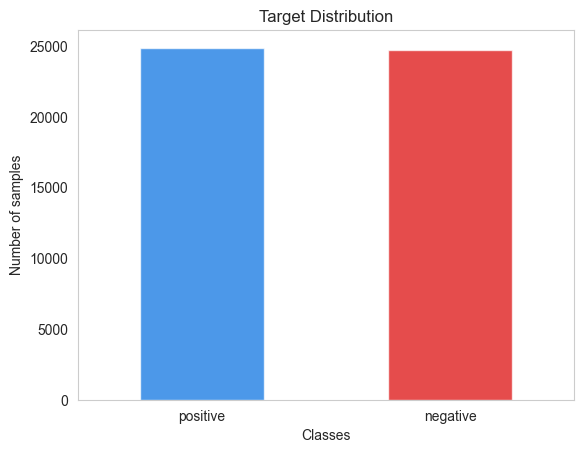

In [11]:
# Visualizing the target distribution

target_plot = df['sentiment'].value_counts().plot(kind='bar', 
                                    title='Target Distribution', 
                                    xlabel='Classes', 
                                    ylabel='Number of samples', 
                                    color=['#006ce0', '#db0000'],
                                    alpha=0.7,
                                    grid=False)
target_plot.set_xticklabels(target_plot.get_xticklabels(), rotation=0)
plt.show()
# save the figure
target_plot.figure.savefig('../plots/target_distribution.png')
# save fig with path windows format and mac format using os library


In [8]:
# clean the text data without removing stop words
import re
import string
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
# clean the df review column and save new dataframe
df['cleaned_review'] = df['review'].apply(clean_text)
df[['review', 'cleaned_review']].head()


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...


In [10]:
# drop the old review column
df = df.drop(columns=['review'])
# rename cleaned_review to review for simplicity
df = df.rename(columns={'cleaned_review': 'review'})
# save csv
df.to_csv('../data/imdb_dataset_cleaned.csv', index=False)
# update path and reload dataframe
path = '../data/imdb_dataset_cleaned.csv'
df = pd.read_csv(path)

In [15]:
df.head()

,sentiment,review
0,positive,one of the other reviewers has mentioned that ...
1,positive,a wonderful little production the filming tech...
2,positive,i thought this was a wonderful way to spend ti...
3,negative,basically theres a family where a little boy j...
4,positive,petter matteis love in the time of money is a ...


###  Plot 2 – Correlation heatmap or boxplot summary for key numeric features.


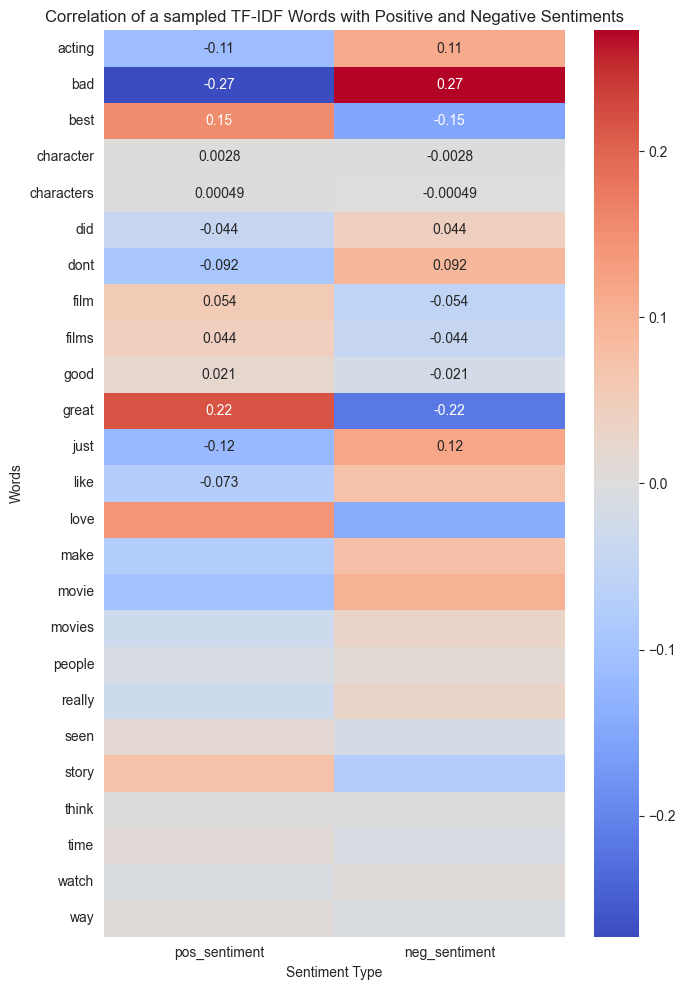

In [11]:
df = df.copy()

# Create binary sentiment columns
df['pos_sentiment'] = (df.sentiment == 'positive').astype(int)
df['neg_sentiment'] = (df.sentiment == 'negative').astype(int)

# TF-IDF feature extraction (limit features for visibility)
vectorizer = TfidfVectorizer(max_features=25, stop_words='english', ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df.review)

# Build DataFrame from TF-IDF matrix
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Add sentiment columns
tfidf_df['pos_sentiment'] = df['pos_sentiment']
tfidf_df['neg_sentiment'] = df['neg_sentiment']

# Compute correlations
corr = tfidf_df.corr()[['pos_sentiment', 'neg_sentiment']].drop(['pos_sentiment', 'neg_sentiment'])

# Plot heatmap
p = plt.figure(figsize=(7, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of a sampled TF-IDF Words with Positive and Negative Sentiments')
plt.xlabel('Sentiment Type')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# Save figure with high quality
p.savefig('../plots/tfidf_correlation_heatmap.png', dpi=300)

## Classification ML

### Train-Validation-Test Split + LR Model

In [12]:
# Train-test split (70% train, 30% test)
x = df['review']
y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# cross-validation on training set (with 5 folds)
cv_scores = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores and mean scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")

# Train model
pipeline.fit(x_train, y_train)

# Step 5: Evaluate on test set
test_accuracy = pipeline.score(x_test, y_test)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Print report 
y_pred = pipeline.predict(x_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Cross-validation scores: [0.88735235 0.89008931 0.89237862 0.8828699  0.89079383]
Mean CV accuracy: 0.8887
Test set accuracy: 0.8915
Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.87      0.89      7410
    positive       0.88      0.91      0.89      7465

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



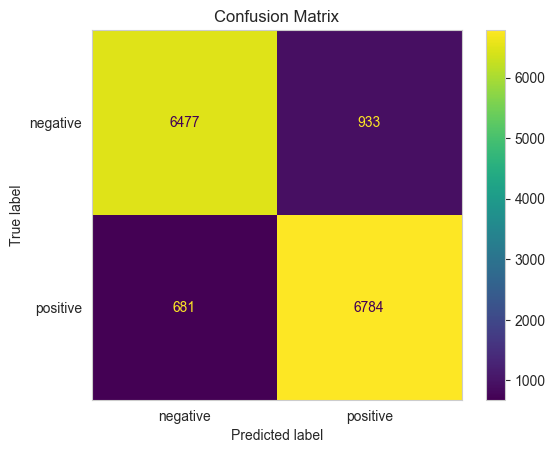

In [18]:
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay.from_estimator(
    pipeline,
    x_test,
    y_test,
    display_labels=pipeline.classes_,
    normalize=None,
    cmap=plt.cm.viridis
    )
cm_display.ax_.set_title('Confusion Matrix')
# remove grid lines
cm_display.ax_.grid(False)
plt.show()
# save confusion matrix figure
cm_display.figure_.savefig('../plots/confusion_matrix.png', dpi=300)

### Learning Curve

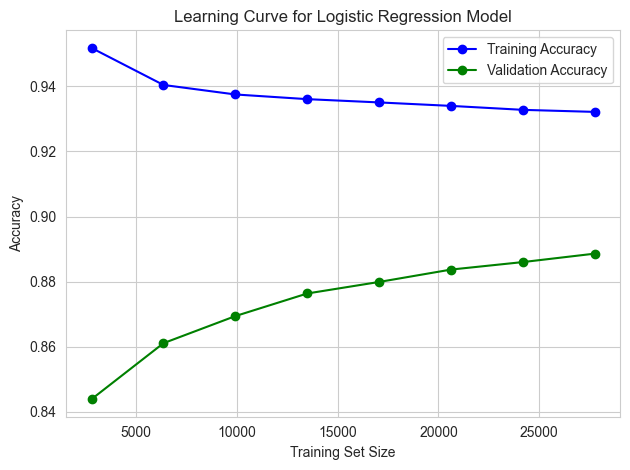

In [20]:
# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, x_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',
    shuffle=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Calculate mean training and validation scores
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### NB model

In [21]:
# Create a pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# cross-validation on training set (with 5 folds)
nb_cv_scores = cross_val_score(nb_pipeline, x_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores and mean scores
print(f"Cross-validation scores: {nb_cv_scores}")
print(f"Mean CV accuracy: {np.mean(nb_cv_scores):.4f}")

# Train the model on training set
nb_pipeline.fit(x_train, y_train)


# Evaluate on test set
nb_test_accuracy = nb_pipeline.score(x_test, y_test)
print(f"Test set accuracy: {nb_test_accuracy:.4f}")

Cross-validation scores: [0.85955056 0.857966   0.8626999  0.86356433 0.85736926]
Mean CV accuracy: 0.8602
Test set accuracy: 0.8633


### learning curve for NB

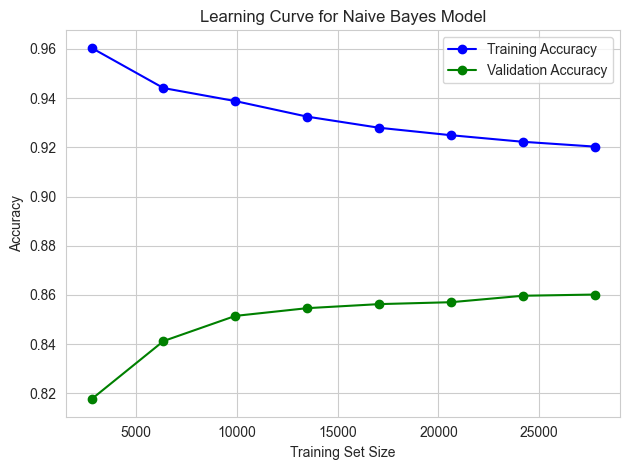

In [22]:
# Generate learning curve data for Naive Bayes model
train_sizes, train_scores, val_scores = learning_curve(
    nb_pipeline, x_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Naive Bayes Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### regression part

Continuous sentiment strength range: -1.000 to 0.999
Linear Regression → MAE: 0.3701 | RMSE: 0.5718
Decision Tree Regressor → MAE: 0.0002 | RMSE: 0.0142


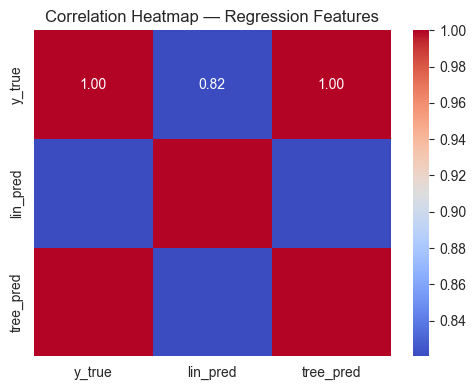

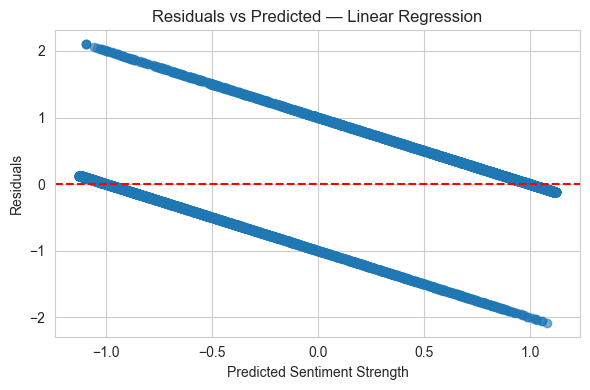

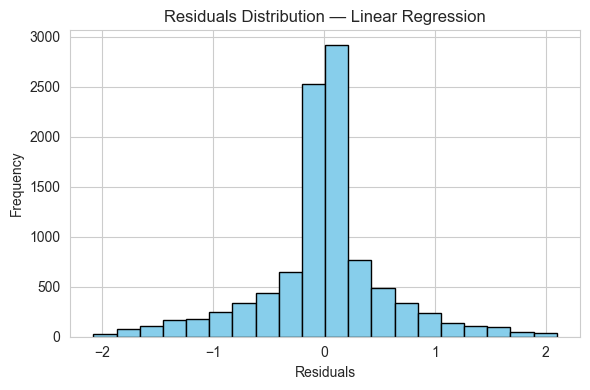

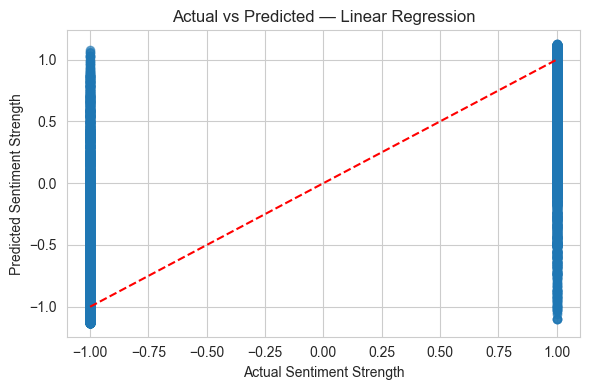

In [ ]:
# ---------------------------------------------------------------
# 📘 Regression Task: Predict Continuous Sentiment Strength
# ---------------------------------------------------------------


# ---------------------------------------------------------------
# 1️⃣ Prepare the Data
# ---------------------------------------------------------------

# Map sentiment labels to ±1 for regression target
df["sentiment_strength_label"] = df["sentiment"].map({"positive": 1, "negative": -1})

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["review"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"]
)

# ---------------------------------------------------------------
# 2️⃣ Compute Continuous Sentiment Strength using Logistic Regression
# ---------------------------------------------------------------

# Logistic regression model trained on text features
log_reg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000))
])

log_reg_pipeline.fit(X_train, y_train)

# Get raw decision scores (logits)
z = log_reg_pipeline.decision_function(X_test)

# Apply sigmoid and scale to [-1, 1]
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sentiment_strength = 2 * sigmoid(z) - 1

print(f"Continuous sentiment strength range: {sentiment_strength.min():.3f} to {sentiment_strength.max():.3f}")

# Prepare true continuous targets
y_true = y_test.map({"positive": 1, "negative": -1}).values

# ---------------------------------------------------------------
# 3️⃣ Train Regression Baselines
# ---------------------------------------------------------------

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(sentiment_strength.reshape(-1, 1), y_true)
lin_pred = lin_reg.predict(sentiment_strength.reshape(-1, 1))

# Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(sentiment_strength.reshape(-1, 1), y_true)
tree_pred = tree_reg.predict(sentiment_strength.reshape(-1, 1))

# ---------------------------------------------------------------
# 4️⃣ Evaluation Metrics
# ---------------------------------------------------------------

def evaluate_regression(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} → MAE: {mae:.4f} | RMSE: {rmse:.4f}")

evaluate_regression(y_true, lin_pred, "Linear Regression")
evaluate_regression(y_true, tree_pred, "Decision Tree Regressor")

# ---------------------------------------------------------------
# 5️⃣ Midpoint Required Plots
# ---------------------------------------------------------------

# ---- Plot 1: Correlation Heatmap ----
corr_df = pd.DataFrame({
    'y_true': y_true,
    'lin_pred': lin_pred,
    'tree_pred': tree_pred
})
plt.figure(figsize=(5, 4))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap — Regression Features')
plt.tight_layout()
plt.show()

# ---- Plot 2: Residuals vs Predicted (Linear Regression) ----
lin_residuals = y_true - lin_pred
plt.figure(figsize=(6, 4))
plt.scatter(lin_pred, lin_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sentiment Strength')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted — Linear Regression')
plt.tight_layout()
plt.show()

# ---- Plot 3: Residuals Histogram (Linear Regression) ----
plt.figure(figsize=(6, 4))
plt.hist(lin_residuals, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution — Linear Regression')
plt.tight_layout()
plt.show()

# ---- Plot 4: Actual vs Predicted (Linear Regression) ----
plt.figure(figsize=(6, 4))
plt.scatter(y_true, lin_pred, alpha=0.6)
plt.plot([-1, 1], [-1, 1], color='red', linestyle='--')
plt.xlabel('Actual Sentiment Strength')
plt.ylabel('Predicted Sentiment Strength')
plt.title('Actual vs Predicted — Linear Regression')
plt.tight_layout()
plt.show()


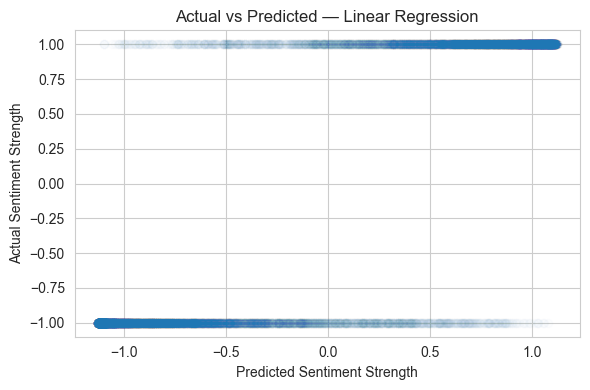

In [ ]:
# ---- Plot 4: Actual vs Predicted (Linear Regression) ----
plt.figure(figsize=(6, 4))
plt.scatter(lin_pred,y_true,  alpha=0.01)
plt.ylabel('Actual Sentiment Strength')
plt.xlabel('Predicted Sentiment Strength')
plt.title('Actual vs Predicted — Linear Regression')
plt.tight_layout()
plt.show()

### NN Nueral Network

In [13]:
# apply nueral network classification model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

def train_mlp(hidden_units_per_layer, lr=0.1, l2=1e-4, max_iter=1000):
    mlp = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=hidden_units_per_layer,
            activation="relu",
            solver="adam",
            alpha=l2,
            learning_rate_init=lr,
            max_iter=max_iter,
            random_state=42,
            shuffle=True,
            early_stopping=True,
            n_iter_no_change=20
        ))
    ])
    mlp.fit(x_train, y_train)
    return mlp



### train the NN and test it

In [29]:
### train the NN and test it and get the f1, precision, recall, accuracy
mlp1 = train_mlp(hidden_units_per_layer=(8,), lr=0.05, l2=1e-4, max_iter=2000)
y_pred_mlp1 = mlp1.predict(x_test)
report_mlp1 = classification_report(y_test, y_pred_mlp1, digits=3, zero_division=0)
print("MLP Classifier Report:\n", report_mlp1)


MLP Classifier Report:
               precision    recall  f1-score   support

    negative      0.885     0.909     0.897      7410
    positive      0.907     0.883     0.895      7465

    accuracy                          0.896     14875
   macro avg      0.896     0.896     0.896     14875
weighted avg      0.896     0.896     0.896     14875



Plotting Confusion Matrix...


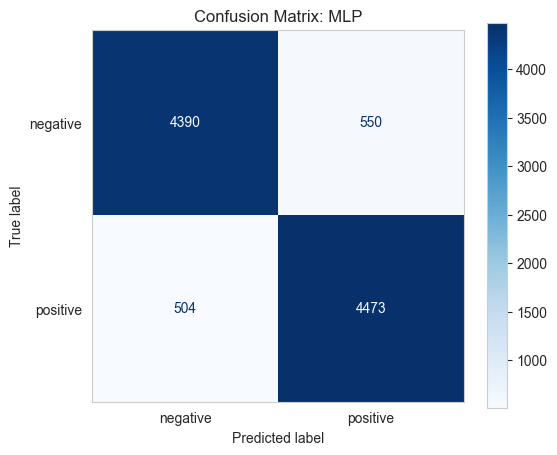

In [ ]:
# 5. Plot Confusion Matrix
print("Plotting Confusion Matrix...")
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(
    mlp1, X_test, y_test, 
    cmap='Blues', 
    ax=ax,
    normalize=None  # Set to 'true' to see percentages instead of counts
)
plt.title("Confusion Matrix: MLP")
plt.grid(False)
plt.show()

### Random search

In [30]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define the Pipeline (Same as before)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MLPClassifier(max_iter=1000, random_state=42, activation='relu', solver='adam', early_stopping=True))
])

# 2. Define the Ranges to Try
# These ranges are selected based on standard best practices for Text Classification
param_dist = {
    # --- MLP Parameters ---
    # Network Size: (64,) is simple, (128,64) captures deeper patterns
    'clf__hidden_layer_sizes': [(64,), (128,), (64, 32)],
    # Regularization (Alpha): High alpha (0.01) simplifies model, Low (0.0001) allows complexity
    'clf__alpha': [0.0001, 0.001],
}

# 3. Setup the Search
# n_iter=5 means it will try 5 random combinations (change to 20 for better results if you have time)
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=6, 
    cv=3,           # 3-fold Cross Validation
    scoring='f1_macro',   # Optimize for F1 Score (balance of precision/recall)
    n_jobs=-1,      # Use all CPU cores
    verbose=1,
    random_state=42
)

# 4. Run the Search (This takes time!)
print("Starting Hyperparameter Tuning...")
random_search.fit(x_train, y_train)

# 5. Get Results
print("\n✅ Best Parameters Found:")
print(random_search.best_params_)
print(f"Best Cross-Validation F1 Score: {random_search.best_score_:.4f}")

# 6. The 'random_search' object now acts as your best model
best_model = random_search.best_estimator_
test_acc = best_model.score(x_test, y_test)
print(f"Test Accuracy of Best Model: {test_acc:.4f}")

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(



✅ Best Parameters Found:
{'clf__hidden_layer_sizes': (64,), 'clf__alpha': 0.0001}
Best Cross-Validation F1 Score: nan
Test Accuracy of Best Model: 0.9029


### Best NN model

In [14]:
mlp1 = train_mlp(hidden_units_per_layer=(64,), lr=0.001, l2=1e-4, max_iter=1000)
y_pred_mlp1 = mlp1.predict(x_test)
report_mlp1 = classification_report(y_test, y_pred_mlp1, digits=3, zero_division=0)
print("MLP Classifier Report:\n", report_mlp1)

MLP Classifier Report:
               precision    recall  f1-score   support

    negative      0.900     0.905     0.903      7410
    positive      0.905     0.901     0.903      7465

    accuracy                          0.903     14875
   macro avg      0.903     0.903     0.903     14875
weighted avg      0.903     0.903     0.903     14875

